In [1]:
import numpy as np
import sys
from pathlib import Path

sys.path.append('../code/')

from mlalgos import BuildNN
from mllib import Utilities,MLUtilities

from time import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()
ml = MLUtilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of `BuildNN` 
### for systematically searching over network architectures and hyperparameters

In [3]:
Plot_Stem = 'buildnn/plots'
Path(Plot_Stem).mkdir(parents=True,exist_ok=True)

Save_Fig = True

## Regression example: 1-d Gaussian, power-sine families
### Function definitions

In [4]:
def func_gauss1d(x,params):
    """ Expect x as 1-d array, params as array of shape (0,), (1,) or (2,). """
    mu = params[0] if len(params) > 0 else 0.0
    sig2 = 10**params[1] if len(params) > 1 else 1.0
    return np.exp(-0.5*(x-mu)**2/sig2)/np.sqrt(2*np.pi*sig2)

def func_powersine(x,params):
    """ Expect x as 1-d array, params as array of shape (0,), (1,), (2,) or (3,). """
    A = params[0] if len(params) > 0 else 1.0
    exponent = params[1] if len(params) > 1 else 0.0
    phase = params[2] if len(params) > 2 else 0.0
    return A*np.fabs(x)**exponent*np.sin(x + phase)**2

In [5]:
Shallow = False # True: shallow+wide arch; False: deep+narrow arch
Depth_Str_Root = 'shallow' if Shallow else 'deep'

Standardize_X = True # whether or not to standardize features
Standardize_Y = True # whether or not to standardize labels

if Standardize_X:
    if Standardize_Y:
        Depth_Str = Depth_Str_Root + '_stdXstdY'
    else:
        Depth_Str = Depth_Str_Root + '_stdX'
else:
    if Standardize_Y:
        Depth_Str = Depth_Str_Root + '_stdY'
    else:
        Depth_Str = Depth_Str_Root + '_nostd'
print(Depth_Str)

Std_Text = 'std: '
if Standardize_X:
    Std_Text += 'X,Y' if Standardize_Y else 'X'
else:
    Std_Text += 'Y' if Standardize_Y else 'none'

deep_stdXstdY


### Training & testing samples

In [6]:
Ftype = 'psin'

ExDict = {'gf1d':{'root':'gf1d_','text':'1-d Gaussian',
                  'func':func_gauss1d,'xbounds':[-2.5,3.0],
                  'pbounds':{'min':[-0.5,-0.2], # minimum mu,lgsig2
                             'max':[ 0.5, 0.2]} # maximum mu,lgsig2
                 },
          'psin':{'root':'psin_','text':'Power-Sine',
                  'func':func_powersine,'xbounds':[0.0,1.5*np.pi],
                  'pbounds':{'min':[-1.0,0.0,-np.pi/9], # minimum A,expo,phase
                             'max':[ 1.0,0.2, np.pi/9]} # maximum A,expo,phase
                 }
         }

if Ftype not in ExDict.keys():
    raise Exception("FType must be one of ["+','.join(key for key in list(ExDict.keys()))+']')

Example_Root = ExDict[Ftype]['root'] + Depth_Str
print(Example_Root)

Example_Text = ExDict[Ftype]['text']

example_func = ExDict[Ftype]['func']
xmin,xmax = ExDict[Ftype]['xbounds']
param_mins = ExDict[Ftype]['pbounds']['min'] 
param_maxs = ExDict[Ftype]['pbounds']['max'] 


psin_deep_stdXstdY


Generating data for Power-Sine family...
... training sample
... sample of size 2500 created
... testing sample
... sample of size 15000 created
... done
0 min 0.00 seconds



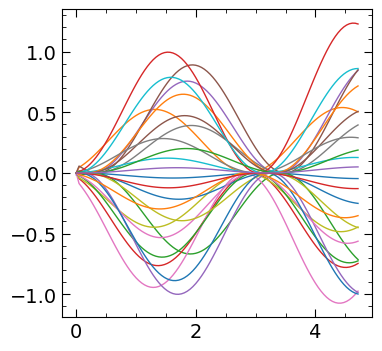

In [7]:
start_time = time()

print('Generating data for '+Example_Text+' family...')

seed = 1983
rng = np.random.RandomState(seed)

#################################################
# Training set
print('... training sample')
n_x_train = 100
xtrain = np.linspace(xmin,xmax,n_x_train)

n_lhc_train = 25 # no. of Latin hypercube samples
n_params = len(param_mins)

# LHC of shape (n_lhc_train,n_params)
if len(param_mins) > 0:
    params_train = ut.gen_latin_hypercube(Nsamp=n_lhc_train,dim=n_params,param_mins=param_mins,param_maxs=param_maxs,rng=rng) 
else:
    params_train = [[]]

n_train = n_lhc_train*n_x_train

X_train = np.zeros((n_train,n_params+1)) # features = {params},x; X will be transposed later
Y_train = np.zeros((1,n_train))

for n in range(n_lhc_train):
    sl = np.s_[n*n_x_train:(n+1)*n_x_train]
    for p in range(n_params):
        X_train[sl,p] = params_train[n,p]
    X_train[sl,-1] = xtrain
    Y_train[0,sl] = example_func(xtrain,params_train[n])

X_train = X_train.T
print('... sample of size {0:d} created'.format(n_train))
#################################################
# Testing set
print('... testing sample')
n_x_test = 200
xtest = (xmax-xmin)*rng.random_sample(n_x_test) + xmin

n_lhc_test = 75 # no. of Latin hypercube samples

# LHC of shape (n_lhc_test,n_params)
if len(param_mins) > 0:
    params_test = ut.gen_latin_hypercube(Nsamp=n_lhc_test,dim=n_params,param_mins=param_mins,param_maxs=param_maxs,rng=rng) 
else:
    params_test = [[]]

n_test = n_lhc_test*n_x_test

X_test = np.zeros((n_test,n_params+1)) # features = {params},x; X will be transposed later
Y_test = np.zeros((1,n_test))

for n in range(n_lhc_test):
    sl = np.s_[n*n_x_test:(n+1)*n_x_test]
    for p in range(n_params):
        X_test[sl,p] = params_test[n,p]
    X_test[sl,-1] = xtest
    Y_test[0,sl] = example_func(xtest,params_test[n])

X_test = X_test.T
print('... sample of size {0:d} created'.format(n_test))
print('... done')
ut.time_this(start_time)

plt.figure(figsize=(4,4))
for n in range(n_lhc_train):
    sl = np.s_[n*n_x_train:(n+1)*n_x_train]
    plt.plot(xtrain,Y_train[0,sl],lw=1)
plt.minorticks_on()
plt.show()

### Network setup and training

#### Non-ensembled

File_Stem: buildnn/psin_deep_stdXstdY
Feed-forward neural network setup...
... found data set of dimension 4 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use mean squared error for hyperparameter comparison
... setup complete
Loaded network with
...    setup params:  {'data_dim': 4, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': True, 'standardize_Y': True, 'file_stem': 'buildnn/psin_deep_stdXstdY/net', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 16, 'wt_decay': 0.0, 'n_layer': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1], 'reg_fun': 'none', 'atypes': ['sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'lin'], 'threshold': None, 'Y_std': array([[0.38080357]]), 'Y_mean': array([[-0.02516468]]), 'X_std': array([[0.57846715],
       [0.0581766 ],
       [0.20082008],
       [1.3701747 ]]), 'X_mean': array([[-0.03828   ],


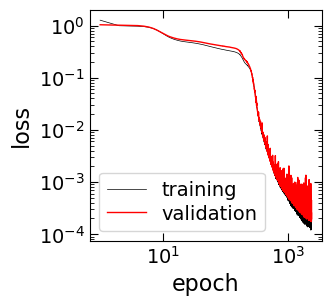

0 min 0.24 seconds



In [8]:
Build = False

Example_Stem_Single = Example_Root

File_Stem = 'buildnn/' + Example_Stem_Single
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Val_Frac = 0.2                                 # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str_Root         # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2 if Shallow else 3                # minimum number of layers (x4 for deep)
Max_Layer = 4 if Shallow else 5                # maximum number of layers (x4 for deep)
Max_Ex = [7,17] if Shallow else [4,6]          # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh']                              # None or subset of ['tanh','relu','lrelu','requ','splus'] 
if Ftype=='gf1d':
    HTypes.append('relu')
else:
    HTypes.append('sin')
LRates = [3e-4,1e-3]                           # None or list of floats: learning rates
if Ftype == 'gf1d':
    LRates.append(3e-3)
Wt_Decays = [0.0,0.1]                          # non-empty list of floats: weight decay values
N_Iter = 5                                     # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Check_After = 300 if Shallow else 1000         # epoch after which to activate validation (early stopping) checks
Test_Type = 'perc' if Ftype=='gf1d' else 'mse' # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 10                                     # number of concurrent processes (only relevant if Parallel = True)

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,standardize_X=Standardize_X,standardize_Y=Standardize_Y,
              max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,
              parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=False)
if Build:
    net,params_train,bts = bnn.trainNN()
    print('Best test stat = {0:.3e}'.format(bts))
    print('Setup params: ',net.params)
    print('Training params: ',params_train)
else:
    net = bnn.load()
    print('Loaded network with')
    print('...    setup params: ',net.params)
    params_train,bts = bnn.load_train()
    print('... best test stat: {0:.3e}'.format(bts))
    print('... training params: ',params_train)

print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training')
plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation')
plt.legend()
plt.show()

residual = np.squeeze(net.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

#### Ensembled

File_Stem: buildnn/psin_deep_stdXstdY_ens
Feed-forward neural network setup...
... found data set of dimension 4 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use mean squared error for hyperparameter comparison
... setup complete
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Loaded ensembled network
Best test stats:
... buildnn/psin_deep_stdXstdY_ens/ensemble/net_r0: 3.923e-03
{'data_dim': 4, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': True, 'standardize_Y': True, 'file_stem': 'buildnn/psin_deep_stdXstdY_ens/ensemble/net_r0', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 20, 'wt_decay': 0.0, 'n_layer': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1], 'reg_fun': 'none', 'atypes': ['sin', 'sin', 'sin', 'sin',

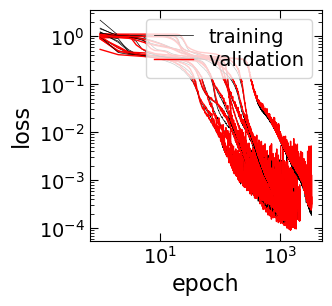

0 min 0.56 seconds



In [9]:
Build = False

Example_Stem_Ens = Example_Root +'_ens'

File_Stem = 'buildnn/' + Example_Stem_Ens
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Val_Frac = 0.2                                 # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str_Root         # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2 if Shallow else 3                # minimum number of layers (x4 for deep)
Max_Layer = 4 if Shallow else 5                # maximum number of layers (x4 for deep)
Max_Ex = [7,17] if Shallow else [4,6]          # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh']                              # None or subset of ['tanh','relu','lrelu','requ','splus'] 
if Ftype=='gf1d':
    HTypes.append('relu')
else:
    HTypes.append('sin')
LRates = [3e-4,1e-3]                           # None or list of floats: learning rates
if Ftype == 'gf1d':
    LRates.append(3e-3)
Wt_Decays = [0.0,0.1]                          # non-empty list of floats: weight decay values
N_Iter = 5                                     # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Check_After = 300 if Shallow else 1000         # epoch after which to activate validation (early stopping) checks
Test_Type = 'perc' if Ftype=='gf1d' else 'mse' # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 10                                     # number of concurrent processes (only relevant if Parallel = True)

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,standardize_X=Standardize_X,standardize_Y=Standardize_Y,
              max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,
              parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=True)
if Build:
    neo = bnn.trainNN()
else:
    neo = bnn.load() # network ensemble object
    print('Loaded ensembled network')

print('Best test stats:')
for key in neo.keys:
    print('... '+key+': {0:.3e}'.format(neo.ensemble[key]['teststat']))
    print(neo.ensemble[key]['net'].params)
    print(neo.ensemble[key]['ptrain'])

print('No. of free params optimized:')
ens_avg_Nwts = []
for key in neo.keys:
    nwts_this = neo.ensemble[key]['net'].calc_N_freeparams()
    print('... '+key+': {0:d}'.format(nwts_this))
    ens_avg_Nwts.append(nwts_this)
ens_avg_Nwts = np.mean(ens_avg_Nwts)
print('... average: {0:.1f}'.format(ens_avg_Nwts))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
for n in range(len(neo.keys)):
    key = neo.keys[n]
    net = neo.ensemble[key]['net']
    plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training' if n==0 else None)
    plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation' if n==0 else None)
plt.legend()
plt.show()

residual_ens = np.squeeze(neo.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

Writing to file: buildnn/plots/psin_deep_stdXstdY.png
median +- 1sigma
...   single: 0.2664 + 5.6282 - 3.1034 %
... ensemble: 0.0857 + 3.4707 - 2.2030 %


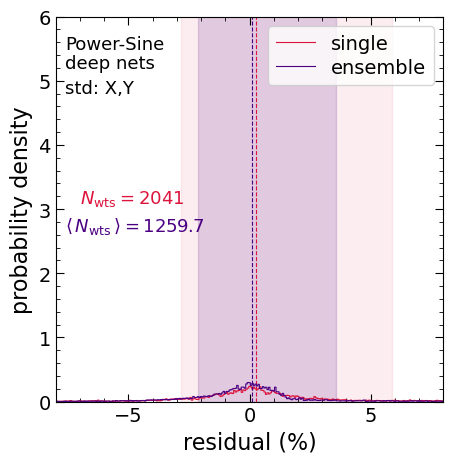

In [10]:
res_16pc = np.percentile(residual,16)*100
res_med  = np.median(residual)*100
res_84pc = np.percentile(residual,84)*100

res_ens_16pc = np.percentile(residual_ens,16)*100
res_ens_med  = np.median(residual_ens)*100
res_ens_84pc = np.percentile(residual_ens,84)*100

bins = np.linspace(-25,25,801)
bin_mid = 0.5*(bins[1:]+bins[:-1])
hist,bins = np.histogram(residual*100,bins=bins,density=False)
hist = hist/residual.size/(bins[1]-bins[0])
hist_ens,bins = np.histogram(residual_ens*100,bins=bins,density=False)
hist_ens = hist_ens/residual_ens.size/(bins[1]-bins[0])

XLoc  = 1.5 if Ftype=='gf1d' else 8.0
dXLoc = 0.1 if Ftype=='gf1d' else 0.4
cols = ['crimson','indigo']
plt.figure(figsize=(5,5))
plt.xlim(-XLoc,XLoc)
plt.ylim(0,6)
plt.xlabel('residual (%)')
plt.ylabel('probability density')
plt.plot(bin_mid,hist,'-',c=cols[0],lw=0.8,drawstyle='steps',label='single')
plt.axvline(res_med,c=cols[0],ls='--',lw=0.8)
plt.fill_betweenx(np.linspace(0,7,10),res_16pc,res_84pc,color=cols[0],alpha=0.075)
plt.plot(bin_mid,hist_ens,'-',c=cols[1],lw=0.8,drawstyle='steps',label='ensemble')
plt.axvline(res_ens_med,c=cols[1],ls='--',lw=0.8)
plt.fill_betweenx(np.linspace(0,7,10),res_ens_16pc,res_ens_84pc,color=cols[1],alpha=0.15)
plt.minorticks_on()
plt.legend(loc='upper right')
plt.text(-XLoc+dXLoc,5.5,Example_Text,fontsize=FS3)
plt.text(-XLoc+dXLoc,5.2,Depth_Str_Root+' nets',fontsize=FS3)
plt.text(-XLoc+dXLoc,4.8,Std_Text,fontsize=FS3)
plt.text(-XLoc+dXLoc*2.5,3.1,'$N_{{\\rm wts}} = {0:d}$'.format(net.calc_N_freeparams()),fontsize=FS3,c=cols[0])
plt.text(-XLoc+dXLoc,2.65,'$\\langle \\, N_{{\\rm wts}} \\, \\rangle = {0:.1f}$'.format(ens_avg_Nwts),fontsize=FS3,c=cols[1])
if Save_Fig:
    outfile = Plot_Stem + '/' + Example_Root + '.png'
    print('Writing to file: '+outfile)
    plt.savefig(outfile,bbox_inches='tight')
else:
    plt.show()

print('median +- 1sigma')
print('...   single: {0:.4f} + {1:.4f} - {2:.4f} %'.format(res_med,res_84pc-res_med,res_med-res_16pc))
print('... ensemble: {0:.4f} + {1:.4f} - {2:.4f} %'.format(res_ens_med,res_ens_84pc-res_ens_med,res_ens_med-res_ens_16pc))

#### Testing activations

File_Stem: buildnn/psin_deep_stdXstdY_act_tanh
Feed-forward neural network setup...
... found data set of dimension 4 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use mean squared error for hyperparameter comparison
... setup complete
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Loaded ensembled network
Best test stats:
... buildnn/psin_deep_stdXstdY_act_tanh/ensemble/net_r0: 4.200e-03
{'data_dim': 4, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': True, 'standardize_Y': True, 'file_stem': 'buildnn/psin_deep_stdXstdY_act_tanh/ensemble/net_r0', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 12, 'wt_decay': 0.0, 'n_layer': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1], 'reg_fun': 'none', 'atypes': ['tanh', 'tanh', 'tanh', '

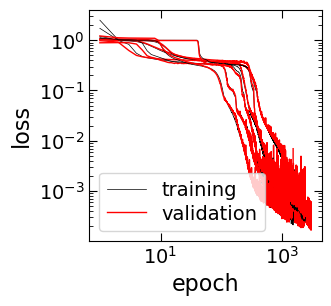

0 min 0.31 seconds

File_Stem: buildnn/psin_deep_stdXstdY_act_relu
Feed-forward neural network setup...
... found data set of dimension 4 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use mean squared error for hyperparameter comparison
... setup complete
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Loaded ensembled network
Best test stats:
... buildnn/psin_deep_stdXstdY_act_relu/ensemble/net_r0: 1.205e-02
{'data_dim': 4, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': True, 'standardize_Y': True, 'file_stem': 'buildnn/psin_deep_stdXstdY_act_relu/ensemble/net_r0', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 12, 'wt_decay': 0.0, 'n_layer': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1], 'reg_fun': 'none', 'atypes': ['relu

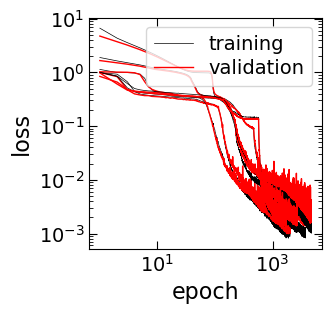

0 min 0.24 seconds

File_Stem: buildnn/psin_deep_stdXstdY_act_lrelu
Feed-forward neural network setup...
... found data set of dimension 4 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use mean squared error for hyperparameter comparison
... setup complete
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Loaded ensembled network
Best test stats:
... buildnn/psin_deep_stdXstdY_act_lrelu/ensemble/net_r0: 1.134e-02
{'data_dim': 4, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': True, 'standardize_Y': True, 'file_stem': 'buildnn/psin_deep_stdXstdY_act_lrelu/ensemble/net_r0', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 12, 'wt_decay': 0.0, 'n_layer': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1], 'reg_fun': 'none', 'atypes': ['l

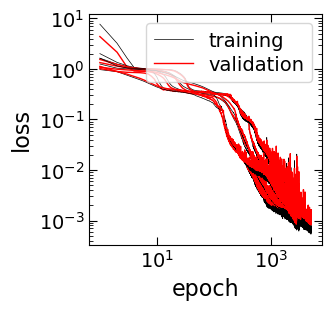

0 min 0.25 seconds

all done!
0 min 0.80 seconds



In [11]:
if Standardize_X & Standardize_Y:
    Build = False
    start_time_all = time()
    
    Activations = ['tanh','relu','lrelu']
    if Shallow:
        Activations += ['requ'] # ReQU leads to exploding gradients in deep networks
        
    residual_act = {}
    Example_Root_Act = Example_Root + '_act'
    
    for act in Activations:
        Example_Stem_Act = Example_Root_Act + '_' + act
        
        File_Stem = 'buildnn/' + Example_Stem_Act
        print('File_Stem:',File_Stem)
        
        Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                                       # remaining used for arch and hyperparam comparisons.
        Val_Frac = 0.2                                 # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
        Arch_Type = 'emulator:'+Depth_Str_Root         # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
        Min_Layer = 2 if Shallow else 3                # minimum number of layers (x4 for deep)
        Max_Layer = 4 if Shallow else 5                # maximum number of layers (x4 for deep)
        Max_Ex = [7,17] if Shallow else [4,6]          # int or list of ints. number of nodes in excess of input dimension 
                                                       # (currently forced to be constant across layers)
        HTypes = [act]                                 # None or subset of ['tanh','relu','lrelu','requ','splus'] 
        LRates = [3e-4,1e-3]                           # None or list of floats: learning rates
        if Ftype == 'gf1d':
            LRates.append(3e-3)
        Wt_Decays = [0.0,0.1]                          # non-empty list of floats: weight decay values
        N_Iter = 5                                     # number of iterations for each choice of arch and hyperparams
        Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
        Seed = None                                    # None or int, random number seed.
        Check_After = 300 if Shallow else 1000         # epoch after which to activate validation (early stopping) checks
        Test_Type = 'perc' if Ftype=='gf1d' else 'mse' # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                                       # relevant for regression (square/hinge loss).
        Parallel = True                                # train networks in parallel
        NProc = 10                                     # number of concurrent processes (only relevant if Parallel = True)
        
        start_time = time()
        bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,standardize_X=Standardize_X,standardize_Y=Standardize_Y,
                      max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,
                      val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,
                      parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=True)
        if Build:
            neo = bnn.trainNN()
        else:
            neo = bnn.load() # network ensemble object
            print('Loaded ensembled network')
        
        print('Best test stats:')
        for key in neo.keys:
            print('... '+key+': {0:.3e}'.format(neo.ensemble[key]['teststat']))
            print(neo.ensemble[key]['net'].params)
            print(neo.ensemble[key]['ptrain'])
        
        print('No. of free params optimized:')
        for key in neo.keys:
            print('... '+key+': {0:d}'.format(neo.ensemble[key]['net'].calc_N_freeparams()))
        
        plt.figure(figsize=(3,3))
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        for n in range(len(neo.keys)):
            key = neo.keys[n]
            net = neo.ensemble[key]['net']
            plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training' if n==0 else None)
            plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation' if n==0 else None)
        plt.legend()
        plt.show()
        
        residual_act[act] = np.squeeze(neo.predict(X_test)/(Y_test + 1e-15) - 1)
        
        ut.time_this(start_time)
    print('all done!')
    ut.time_this(start_time_all)

median +- 1sigma
... tanh: -0.1251 + 3.0761 - 3.2069 %
... relu: -1.9064 + 14.2875 - 15.2933 %
... lrelu: -1.9623 + 21.3368 - 18.0243 %
Writing to file: buildnn/plots/psin_deep_stdXstdY_act.png


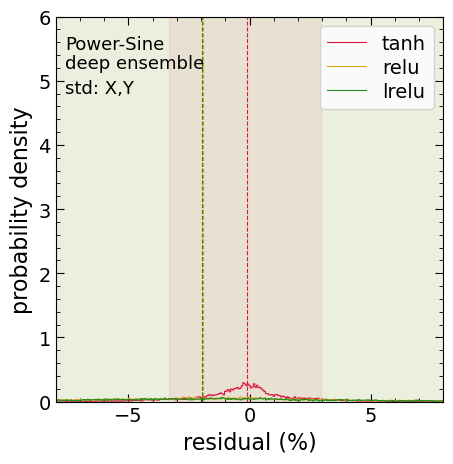

In [12]:
if Standardize_X & Standardize_Y:
    res_act_16pc = {}
    res_act_med  = {}
    res_act_84pc = {}
    
    bins = np.linspace(-25,25,801)
    bin_mid = 0.5*(bins[1:]+bins[:-1])
    hist_act = {}
    
    cols = ['crimson','goldenrod','forestgreen','indigo']
    cols_dict = {Activations[a]:cols[a] for a in range(len(Activations))}
    
    print('median +- 1sigma')
    for act in Activations:
        res_act_16pc[act] = np.percentile(residual_act[act],16)*100
        res_act_med[act]  = np.median(residual_act[act])*100
        res_act_84pc[act] = np.percentile(residual_act[act],84)*100
        hist_this,bins = np.histogram(residual_act[act]*100,bins=bins,density=False)
        hist_act[act] = hist_this/residual_act[act].size/(bins[1]-bins[0])
        print('... '+act+': {0:.4f} + {1:.4f} - {2:.4f} %'.format(res_act_med[act],res_act_84pc[act]-res_act_med[act],
                                                                  res_act_med[act]-res_act_16pc[act]))
    
    plt.figure(figsize=(5,5))
    XLoc = 1.5 if Ftype=='gf1d' else 8.0
    dXLoc = 0.1 if Ftype=='gf1d' else 0.4
    plt.xlim(-XLoc,XLoc)
    plt.ylim(0,6)
    plt.xlabel('residual (%)')
    plt.ylabel('probability density')
    for act in Activations:
        plt.plot(bin_mid,hist_act[act],'-',c=cols_dict[act],lw=0.8,drawstyle='steps',label=act)
        plt.axvline(res_act_med[act],c=cols_dict[act],ls='--',lw=0.8)
        plt.fill_betweenx(np.linspace(0,7,10),res_act_16pc[act],res_act_84pc[act],color=cols_dict[act],alpha=0.075)
    plt.minorticks_on()
    plt.legend(loc='upper right')
    plt.text(-XLoc+dXLoc,5.5,Example_Text,fontsize=FS3)
    plt.text(-XLoc+dXLoc,5.2,Depth_Str_Root+' ensemble',fontsize=FS3)
    plt.text(-XLoc+dXLoc,4.8,Std_Text,fontsize=FS3)
    if Save_Fig:
        outfile = Plot_Stem + '/' + Example_Root_Act + '.png'
        print('Writing to file: '+outfile)
        plt.savefig(outfile,bbox_inches='tight')
    else:
        plt.show()

#### Tanh vs SoftPlus/Sine

File_Stem: buildnn/psin_deep_stdXstdY_plus_tanh
Feed-forward neural network setup...
... found data set of dimension 4 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use mean squared error for hyperparameter comparison
... setup complete
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Loaded ensembled network
Best test stats:
... buildnn/psin_deep_stdXstdY_plus_tanh/ensemble/net_r0: 4.931e-03
{'data_dim': 4, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': True, 'standardize_Y': True, 'file_stem': 'buildnn/psin_deep_stdXstdY_plus_tanh/ensemble/net_r0', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 12, 'wt_decay': 0.0, 'n_layer': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1], 'reg_fun': 'none', 'atypes': ['tanh', 'tanh', 'tanh'

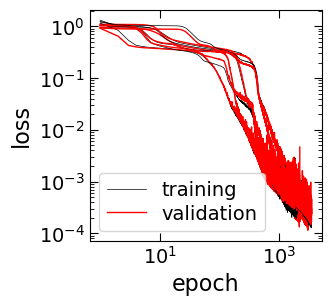

0 min 0.33 seconds

File_Stem: buildnn/psin_deep_stdXstdY_plus_sin
Feed-forward neural network setup...
... found data set of dimension 4 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use mean squared error for hyperparameter comparison
... setup complete
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Loaded ensembled network
Best test stats:
... buildnn/psin_deep_stdXstdY_plus_sin/ensemble/net_r0: 3.337e-03
{'data_dim': 4, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': True, 'standardize_Y': True, 'file_stem': 'buildnn/psin_deep_stdXstdY_plus_sin/ensemble/net_r0', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 12, 'wt_decay': 0.0, 'n_layer': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1], 'reg_fun': 'none', 'atypes': ['sin'

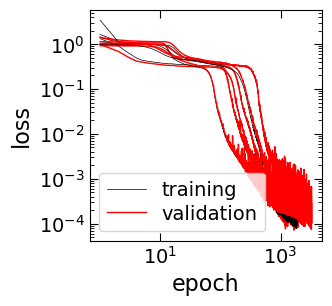

0 min 0.29 seconds

all done!
0 min 0.62 seconds



In [13]:
Build = False
start_time_all = time()

Activations_Plus = ['tanh']
if Ftype == 'gf1d':
    Activations_Plus.append('splus')
else:
    Activations_Plus.append('sin')

residual_plus = {}
Example_Root_Plus = Example_Root + '_plus'

for act in Activations_Plus:
    Example_Stem_Plus = Example_Root_Plus + '_' + act
    
    File_Stem = 'buildnn/' + Example_Stem_Plus
    print('File_Stem:',File_Stem)
    
    Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                                   # remaining used for arch and hyperparam comparisons.
    Val_Frac = 0.2                                 # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
    Arch_Type = 'emulator:'+Depth_Str_Root         # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
    Min_Layer = 2 if Shallow else 3                # minimum number of layers (x4 for deep)
    Max_Layer = 4 if Shallow else 5                # maximum number of layers (x4 for deep)
    Max_Ex = [7,17] if Shallow else [4,6]          # int or list of ints. number of nodes in excess of input dimension 
                                                   # (currently forced to be constant across layers)
    HTypes = [act]                                 # None or subset of ['tanh','relu','lrelu','requ','splus'] 
    LRates = [3e-4,1e-3]                           # None or list of floats: learning rates
    if Ftype == 'gf1d':
        LRates.append(3e-3)
    Wt_Decays = [0.0,0.1]                          # non-empty list of floats: weight decay values
    N_Iter = 5                                     # number of iterations for each choice of arch and hyperparams
    Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
    Seed = None                                    # None or int, random number seed.
    Check_After = 300 if Shallow else 1000         # epoch after which to activate validation (early stopping) checks
    Test_Type = 'perc' if Ftype=='gf1d' else 'mse' # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                                   # relevant for regression (square/hinge loss).
    Parallel = True                                # train networks in parallel
    NProc = 10                                     # number of concurrent processes (only relevant if Parallel = True)
    
    start_time = time()
    bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,standardize_X=Standardize_X,standardize_Y=Standardize_Y,
                  max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,
                  val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,
                  parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=True)
    if Build:
        neo = bnn.trainNN()
    else:
        neo = bnn.load() # network ensemble object
        print('Loaded ensembled network')
    
    print('Best test stats:')
    for key in neo.keys:
        print('... '+key+': {0:.3e}'.format(neo.ensemble[key]['teststat']))
        print(neo.ensemble[key]['net'].params)
        print(neo.ensemble[key]['ptrain'])
    
    print('No. of free params optimized:')
    for key in neo.keys:
        print('... '+key+': {0:d}'.format(neo.ensemble[key]['net'].calc_N_freeparams()))
    
    plt.figure(figsize=(3,3))
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    for n in range(len(neo.keys)):
        key = neo.keys[n]
        net = neo.ensemble[key]['net']
        plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training' if n==0 else None)
        plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation' if n==0 else None)
    plt.legend()
    plt.show()
    
    residual_plus[act] = np.squeeze(neo.predict(X_test)/(Y_test + 1e-15) - 1)
    
    ut.time_this(start_time)
print('all done!')
ut.time_this(start_time_all)

median +- 1sigma
... tanh: 0.3104 + 4.9924 - 2.2482 %
... sin: 0.2597 + 4.3584 - 2.5609 %
Writing to file: buildnn/plots/psin_deep_stdXstdY_plus.png


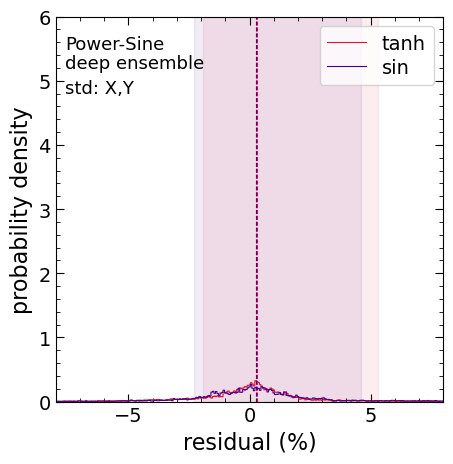

In [14]:
res_plus_16pc = {}
res_plus_med  = {}
res_plus_84pc = {}

bins = np.linspace(-25,25,801)
bin_mid = 0.5*(bins[1:]+bins[:-1])
hist_plus = {}

cols = ['crimson','indigo']
cols_dict_plus = {Activations_Plus[a]:cols[a] for a in range(len(Activations_Plus))}

print('median +- 1sigma')
for act in Activations_Plus:
    res_plus_16pc[act] = np.percentile(residual_plus[act],16)*100
    res_plus_med[act]  = np.median(residual_plus[act])*100
    res_plus_84pc[act] = np.percentile(residual_plus[act],84)*100
    hist_this,bins = np.histogram(residual_plus[act]*100,bins=bins,density=False)
    hist_plus[act] = hist_this/residual_plus[act].size/(bins[1]-bins[0])
    print('... '+act+': {0:.4f} + {1:.4f} - {2:.4f} %'.format(res_plus_med[act],res_plus_84pc[act]-res_plus_med[act],
                                                              res_plus_med[act]-res_plus_16pc[act]))

plt.figure(figsize=(5,5))
XLoc = 1.5 if Ftype=='gf1d' else 8.0
dXLoc = 0.1 if Ftype=='gf1d' else 0.4
plt.xlim(-XLoc,XLoc)
plt.ylim(0,6)
plt.xlabel('residual (%)')
plt.ylabel('probability density')
for act in Activations_Plus:
    plt.plot(bin_mid,hist_plus[act],'-',c=cols_dict_plus[act],lw=0.8,drawstyle='steps',label=act)
    plt.axvline(res_plus_med[act],c=cols_dict_plus[act],ls='--',lw=0.8)
    plt.fill_betweenx(np.linspace(0,7,10),res_plus_16pc[act],res_plus_84pc[act],color=cols_dict_plus[act],alpha=0.075)
plt.minorticks_on()
plt.legend(loc='upper right')
plt.text(-XLoc+dXLoc,5.5,Example_Text,fontsize=FS3)
plt.text(-XLoc+dXLoc,5.2,Depth_Str_Root+' ensemble',fontsize=FS3)
plt.text(-XLoc+dXLoc,4.8,Std_Text,fontsize=FS3)
if Save_Fig:
    outfile = Plot_Stem + '/' + Example_Root_Plus + '.png'
    print('Writing to file: '+outfile)
    plt.savefig(outfile,bbox_inches='tight')
else:
    plt.show()